In [1]:
!python -m pip install multiple-hypothesis-testing

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    # import glob; print(glob.glob('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis/*'))
    import sys
    sys.path.append('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis')
except:
    pass

In [3]:
from Synthetic_Data_Generators import Multi_Class_Normal_Population as Data_Generator
from Synthetic_Data_Generators import Two_Lists_Tuple
from Higher_Criticism import Higher_Criticism
higher_criticism = Higher_Criticism(use_import=False, gamma=1.0)

In [4]:
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'monospace'


In [5]:

N = 1000
monte_carlo=10000
alpha = 0.05

mus = [1.0]
signal_fraction = [0] + list(10**-np.linspace(1,3,5))
parameters_tuple = Two_Lists_Tuple(mus,signal_fraction)
collected_data = []
for mu, fraction in parameters_tuple:
    print(f'Collecting measurments for signal mu={mu:.2f} signal size={fraction*100:.2f}%')
    n = int(N*fraction)
    data_generator = Data_Generator(sizes=[N-n,n], mus=[0,mu], sigmas=[1,1])
    nums_rejected = []
    best_objectives = []
    first_drawdown = []
    fooled_by_randomness = []
    for i in tqdm(range(monte_carlo)):
        data_generator.generate(seed=i)
        higher_criticism.run_unsorted_p(data_generator.p_values)
        # collecting data from objective function
        best_objectives.append(higher_criticism.best_objective)
        nums_rejected.append(higher_criticism.original_num_rejected)
        objectives = higher_criticism.objectives
        first_drawdown.append(objectives[0] - objectives[:higher_criticism.original_num_rejected+1].min())
        fooled_by_randomness.append(higher_criticism.num_rejected > 0)

    fooled_by_randomness = np.array(fooled_by_randomness)
    collected_data.append((nums_rejected,best_objectives,first_drawdown,fooled_by_randomness))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:16<00:00, 616.11it/s]


100%|██████████| 10000/10000 [00:15<00:00, 639.93it/s]


100%|██████████| 10000/10000 [00:16<00:00, 611.21it/s]


100%|██████████| 10000/10000 [00:16<00:00, 595.56it/s]


100%|██████████| 10000/10000 [00:15<00:00, 633.50it/s]


100%|██████████| 10000/10000 [00:15<00:00, 635.19it/s]


In [6]:

print(f'Fooled by Randomness: {sum(fooled_by_randomness)/monte_carlo*100:.2f}%')

Fooled by Randomness: 97.73%


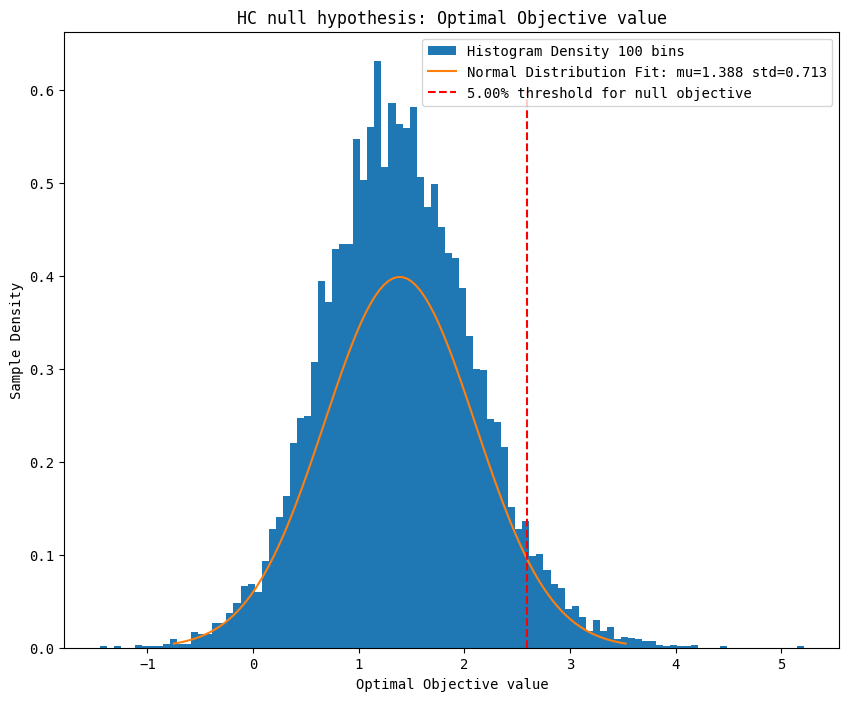

In [7]:
seed_null_objective_95 = np.argsort(best_objectives)[int(monte_carlo*(1-alpha))]
mu = np.mean(best_objectives)
std = np.std(best_objectives)
bins = int(len(best_objectives)**0.5 + 0.01)
plt.figure(figsize=(10,8))
plt.title(label=f'HC null hypothesis: Optimal Objective value')
plt.hist(best_objectives, bins=bins, density=True, label=f'Histogram Density {bins} bins')
x = np.linspace(-3, +3, 100)
plt.plot(mu + x*std, scipy.stats.norm.pdf(x, 0, 1), label=f'Normal Distribution Fit: mu={mu:.3f} std={std:.3f}')
plt.vlines(ymin=0, ymax=0.6, x=best_objectives[seed_null_objective_95], linestyles='dashed', colors='red',\
           label=f'{alpha*100:.2f}% threshold for null objective')
plt.xlabel(xlabel='Optimal Objective value')
plt.ylabel(ylabel='Sample Density')
plt.legend()
plt.show()


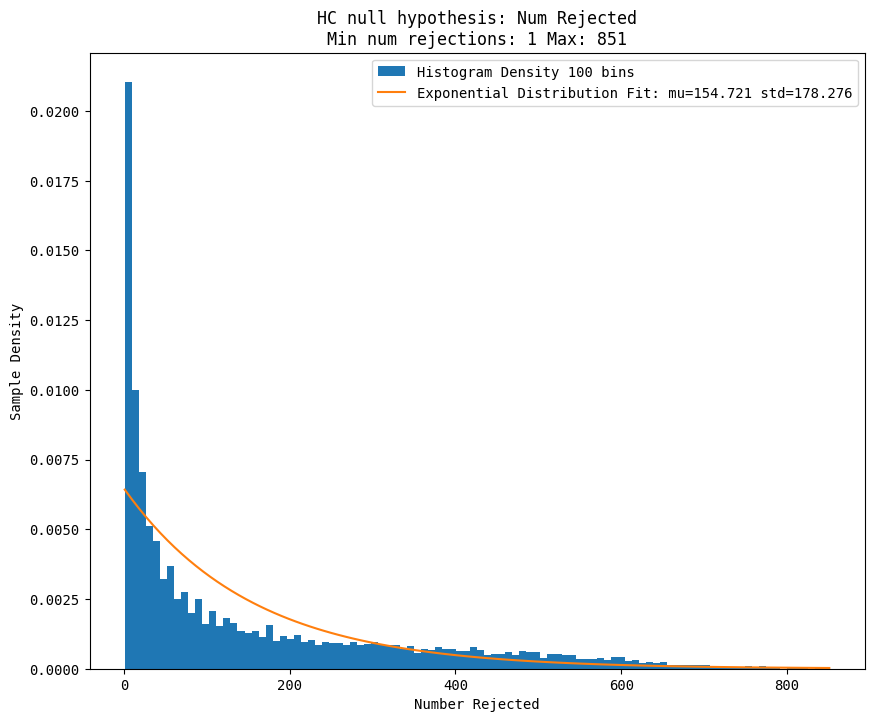

In [8]:
mu = np.mean(nums_rejected)
std = np.std(nums_rejected)
bins = int(len(nums_rejected)**0.5 + 0.01)
min_rejected = np.min(nums_rejected)
max_rejected = np.max(nums_rejected)
seed_null_rejection_95 = np.argsort(nums_rejected)[int(monte_carlo*(1-alpha))]
plt.figure(figsize=(10,8))
plt.title(label=f'HC null hypothesis: Num Rejected\n' +\
          f'Min num rejections: {min_rejected} Max: {max_rejected}')
plt.hist(nums_rejected, bins=bins, density=True, label=f'Histogram Density {bins} bins')
x = np.linspace(min_rejected,max_rejected,100)
plt.plot(x, scipy.stats.expon.pdf(x, loc=min_rejected-1, scale=mu),
         label=f'Exponential Distribution Fit: mu={mu:.3f} std={std:.3f}')
plt.xlabel(xlabel='Number Rejected')
plt.ylabel(ylabel='Sample Density')
plt.legend()
plt.show()



In [9]:
first_drawdown_fooled = first_drawdown[fooled_by_randomness]
mu = np.mean(first_drawdown_fooled)
std = np.std(first_drawdown_fooled)
bins = int(len(first_drawdown_fooled)**0.5 + 0.01)
ind_seed_sorted_drawdown = np.argsort(first_drawdown_fooled)
plt.figure(figsize=(10,8))
plt.title(label=f'HC null hypothesis: First Drawdown')
plt.hist(first_drawdown_fooled, bins=bins, density=True, label=f'Histogram Density {bins} bins')
x = np.linspace(min(first_drawdown_fooled),max(first_drawdown_fooled),100)
plt.plot(x, scipy.stats.expon.pdf(x, loc=min(first_drawdown_fooled)-1, scale=mu),
         label=f'Exponential Distribution Fit: mu={mu:.3f} std={std:.3f}')
plt.xlabel(xlabel='First Drawdown')
plt.ylabel(ylabel='Sample Density')
plt.legend()
plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index

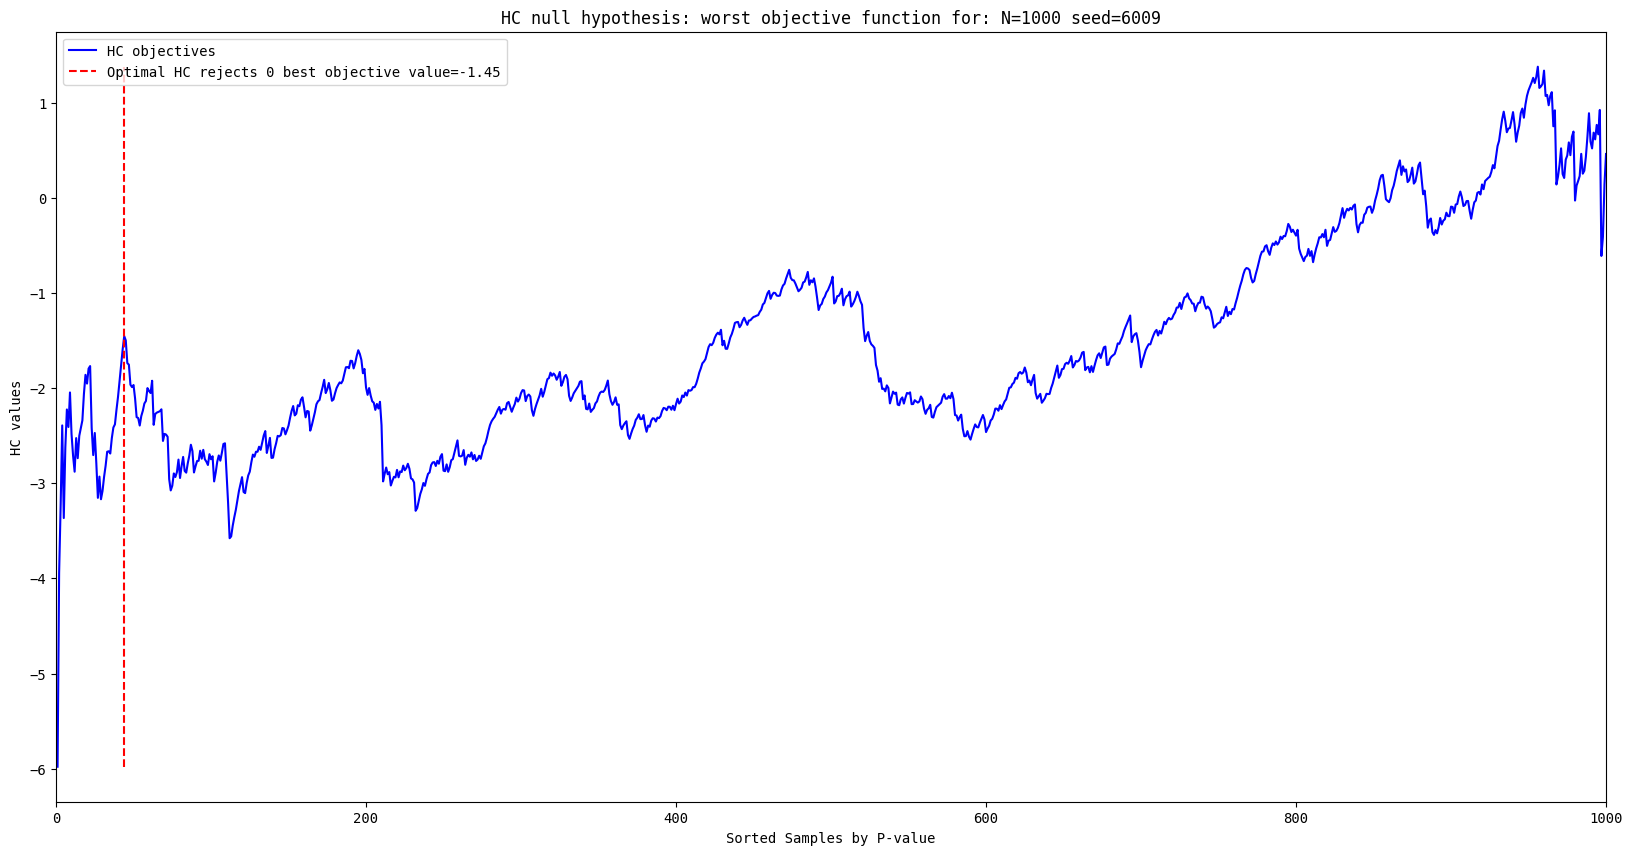

In [ ]:

seed_worst_objective = np.argmin(best_objectives)
np.random.seed(seed=seed_worst_objective)
p = np.random.uniform(size=N)
higher_criticism.run_unsorted_p(p)
higher_criticism.plot_objectives(f'HC null hypothesis: worst objective function for: N={N} seed={seed_worst_objective}')


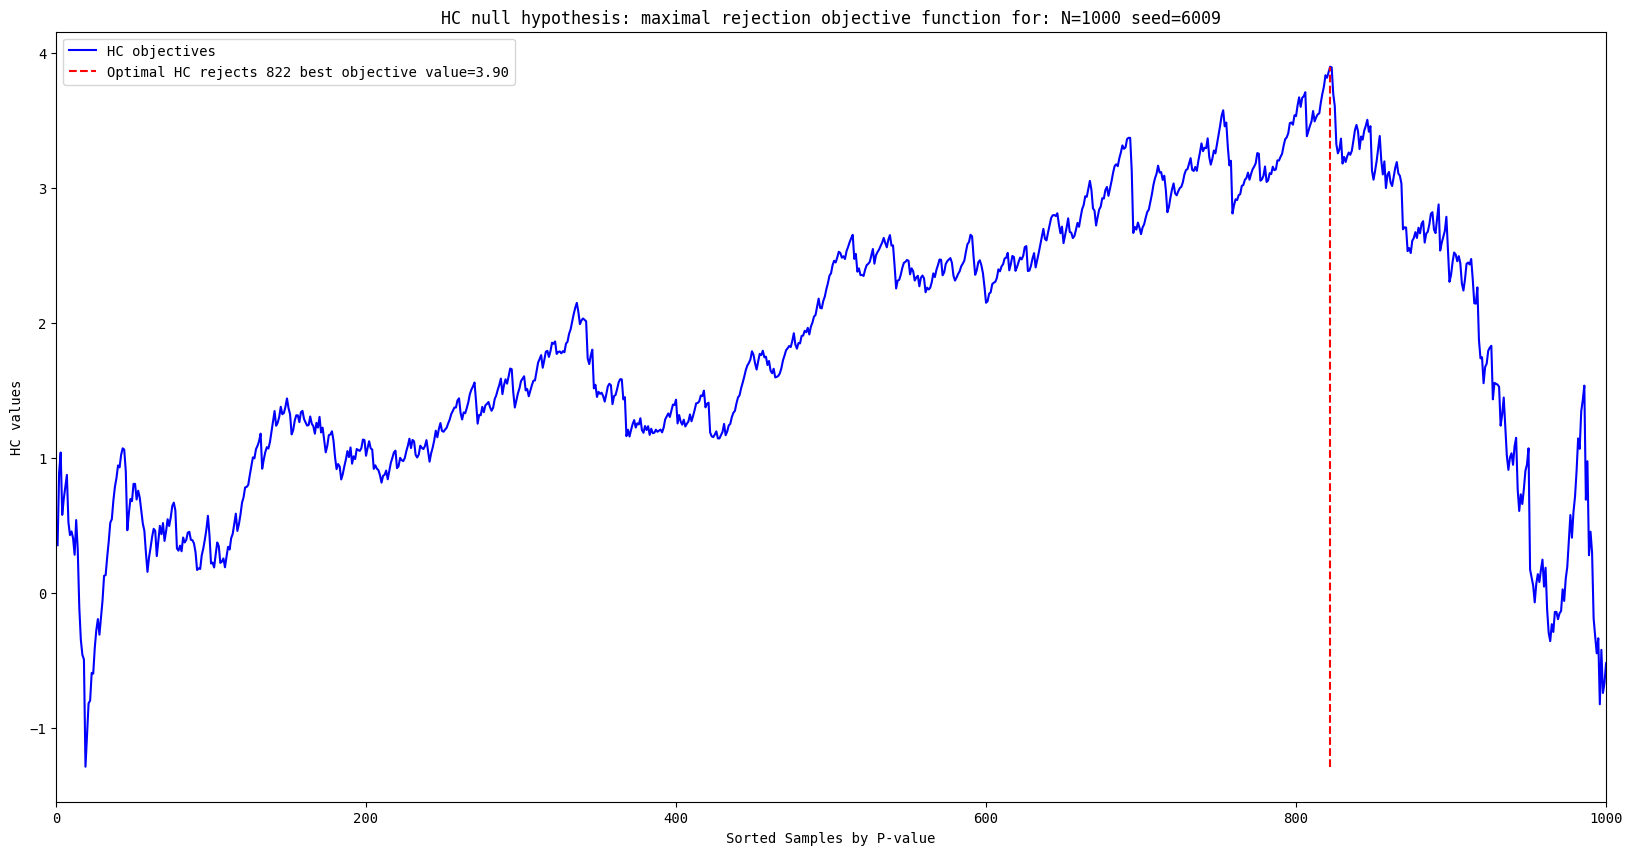

In [ ]:

seed_maximal_rejections = np.argmax(nums_rejected)
np.random.seed(seed=seed_maximal_rejections)
p = np.random.uniform(size=N)
higher_criticism.run_unsorted_p(p)
higher_criticism.plot_objectives(f'HC null hypothesis: maximal rejection objective function for: N={N} seed={seed_worst_objective}')


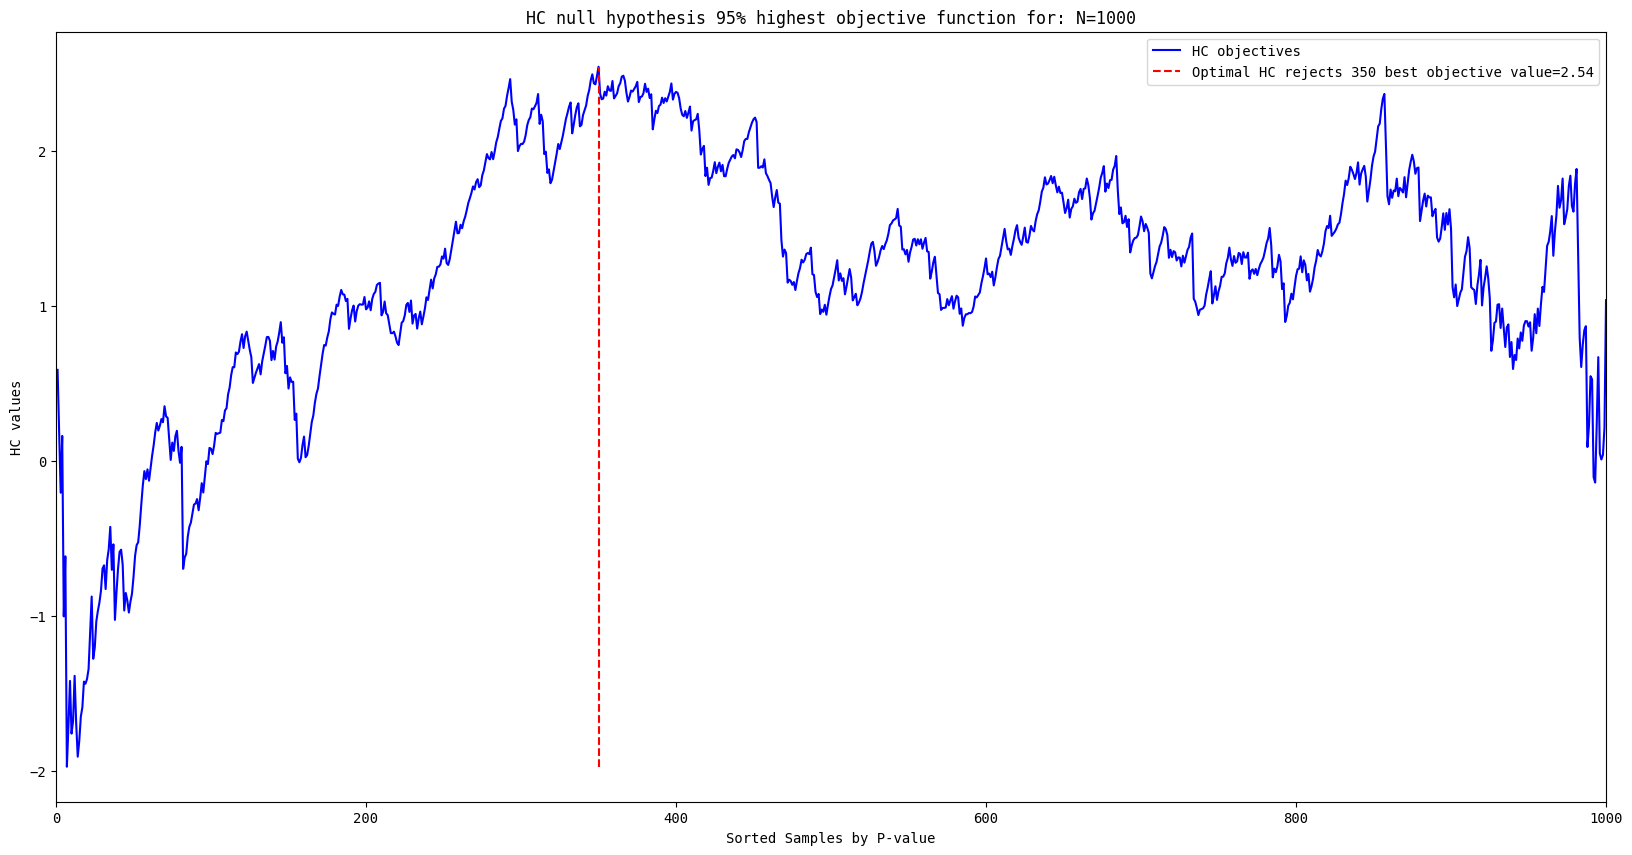

In [ ]:
np.random.seed(seed=seed_null_objective_95)
p = np.random.uniform(size=N)
higher_criticism.run_unsorted_p(p)
higher_criticism.plot_objectives(f'HC null hypothesis 95% highest objective function for: N={N}')


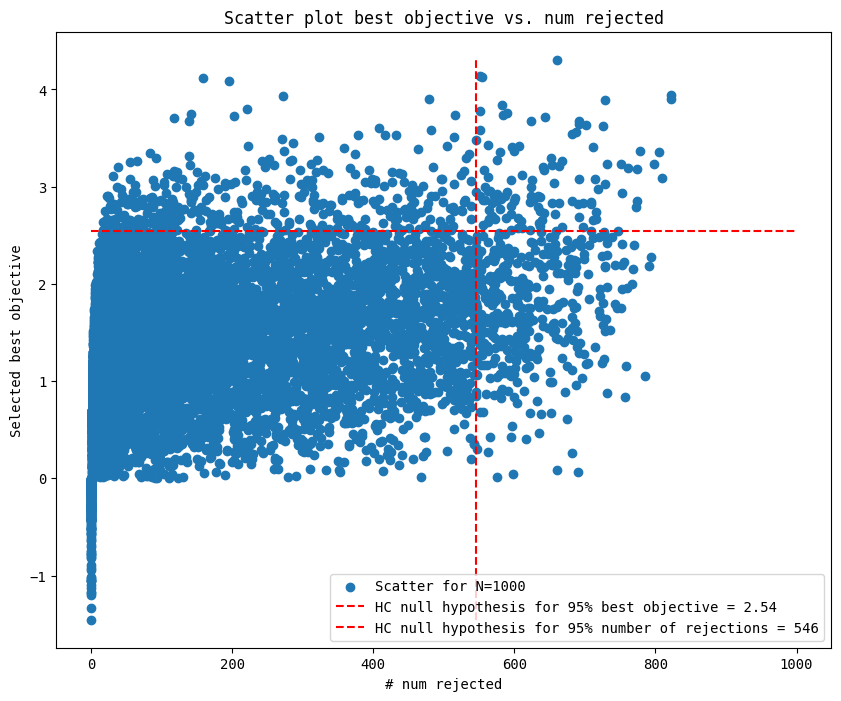

In [ ]:
best_objective_threshold = best_objectives[seed_null_objective_95]
seed_null_rejection_95 = np.argsort(nums_rejected)[int(monte_carlo*(1-alpha))]
best_rejection_threshold = nums_rejected[seed_null_rejection_95]
plt.figure(figsize=(10,8))
plt.title(label=f'Scatter plot best objective vs. num rejected')
plt.scatter(x = nums_rejected, y=best_objectives, label=f'Scatter for N={N}')
plt.hlines(xmin=0, xmax=N-1, y=best_objective_threshold,
           label=f'HC null hypothesis for 95% best objective = {best_objective_threshold:.2f}',
           linestyles='dashed', colors='red')
plt.vlines(ymin=np.min(best_objectives), ymax=np.max(best_objectives), x=best_rejection_threshold,
           label=f'HC null hypothesis for 95% number of rejections = {best_rejection_threshold}',
           linestyles='dashed', colors='red')
plt.xlabel(xlabel='# num rejected')
plt.ylabel(ylabel='Selected best objective')
plt.legend()
plt.show()
